In [1]:
# Create VAE to generate new images of handwritten digits
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [0, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) / 255
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) / 255

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')


2024-01-24 22:57:50.785414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 22:57:50.785475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 22:57:50.786934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 22:57:50.796977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 22:57:52.827462: W tensorflow/compiler/tf2

In [2]:
# Create conditional encoder for VAE
input1 = tf.keras.layers.Input(shape=(28,28,1))
input2 = tf.keras.layers.Input(shape=(1,))
y = tf.keras.layers.Embedding(10, 50)(input2)
y = tf.keras.layers.Dense(28*28, activation='relu')(y)
y = tf.keras.layers.Reshape((28,28,1))(y)
x = tf.keras.layers.concatenate([input1, y])
x = tf.keras.layers.Conv2D(256,(3,3), (2,2),activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256,(3,3),(2,2), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256,(3,3),(2,2), activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(100)(x)

encoder = tf.keras.Model([input1, input2], out)


# Create decoder for VAE
input3 = tf.keras.layers.Input(shape=(50,))
input4 = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(7*7*256, activation='relu')(input3)
x = tf.keras.layers.Reshape((7,7,256))(x)
y = tf.keras.layers.Embedding(10, 50)(input4)
y = tf.keras.layers.Dense(7*7, activation='relu')(y)
y = tf.keras.layers.Reshape((7,7,1))(y)
x = tf.keras.layers.concatenate([x, y])
x = tf.keras.layers.Conv2DTranspose(256,(3,3), (2,2), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(256,(3,3),(2,2), activation='relu', padding='same')(x)
out = tf.keras.layers.Conv2DTranspose(1,(3,3),(1,1), padding='same')(x)

decoder = tf.keras.Model([input3, input4], out)

encoder.summary()
decoder.summary()
@tf.function
def sample(eps=None, labels=None):
    if eps is None:
        eps = tf.random.normal(shape=(50,1))
    return decode(eps,labels, apply_sigmoid=True)

def decode(z, labels, apply_sigmoid=False):
    logits = decoder([z, labels])
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits
def encode(x, labels):
    mean, logvar = tf.split(encoder([x, labels]), num_or_size_splits=2, axis=1)
    return mean, logvar
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean


2024-01-24 22:57:57.457607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 784)               39984     ['embedding[0][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                              

In [3]:
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi=64)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [4]:
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(x, labels):
    mean, logvar = encode(x, labels)
    z = reparameterize(mean, logvar)
    x_logit = decode(z, labels)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(x, labels):
    with tf.GradientTape() as tape:
        loss = compute_loss(x, labels)
    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss
    

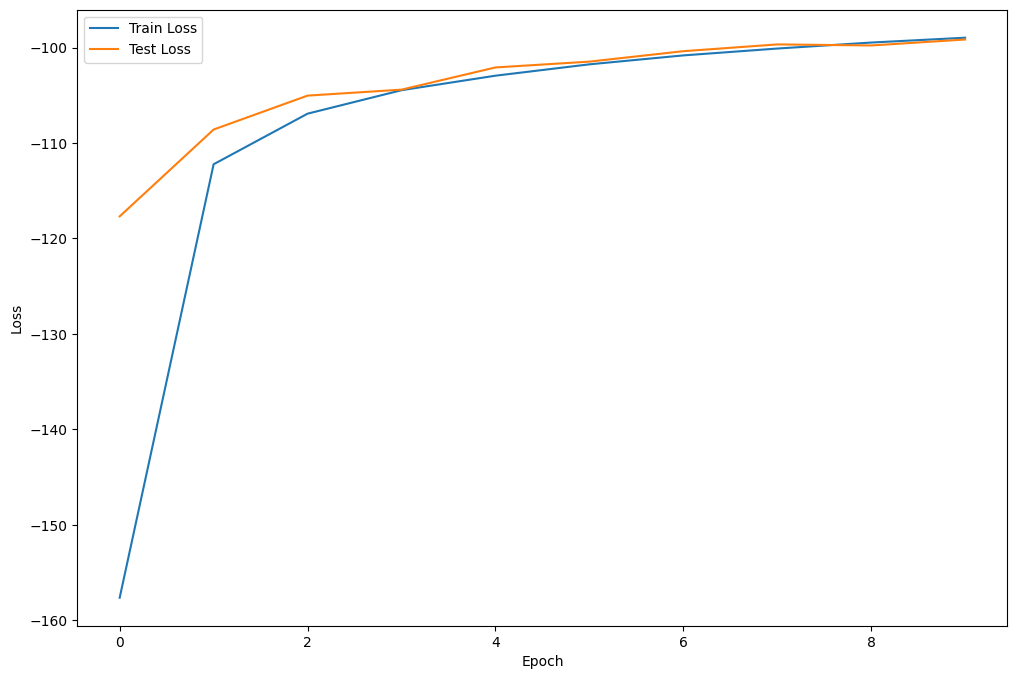

In [5]:
epochs = 10
import time
from IPython import display

# def generate_images(epoch, test_sample):
#     mean, logvar = encode(test_sample)
#     z = reparameterize(mean, logvar)
#     predictions = sample(z)
#     fig = plt.figure(figsize=(4,4))
    
#     for i in range(predictions.shape[0]):
#         plt.subplot(4,4,i+1)
#         plt.imshow(predictions[i,:,:,0], cmap='gray')
#         plt.axis('off')
#     plt.show()
test_labels = tf.reshape(test_labels, (10000,1))
train_labels = tf.reshape(train_labels, (60000,1))

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(32)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels).batch(32)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels).batch(32)



for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16,:,:,:]
for test_label in test_labels_dataset.take(1):
    test_label_sample = test_label[0:16]
    

train_loss_results = []
test_loss_results = []  
for epoch in range(1, epochs + 1):
    start_time = time.time()
    loss = tf.keras.metrics.Mean()
    for train_x, train_label in zip(train_dataset, train_labels_dataset):
        loss(train_step(train_x, train_label))
    end_time = time.time()
    train_loss = -loss.result()
    loss = tf.keras.metrics.Mean()
    for test_x, test_label in zip(test_dataset, test_labels_dataset):
        loss(compute_loss(test_x, test_label))
    elbo = -loss.result()
    display.clear_output(wait=False)
    train_loss_results.append(train_loss)
    test_loss_results.append(elbo)
    plt.figure(figsize=(12,8))
    plt.plot(train_loss_results)
    plt.plot(test_loss_results)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Test Loss'])
    plt.show()
    
    
    # print('Epoch: {}, Train set loss: {} Test set ELBO: {}, time elapse for current epoch: {}'
        #   .format(epoch, train_loss, elbo, end_time - start_time))
    # generate_images(epoch, test_sample)

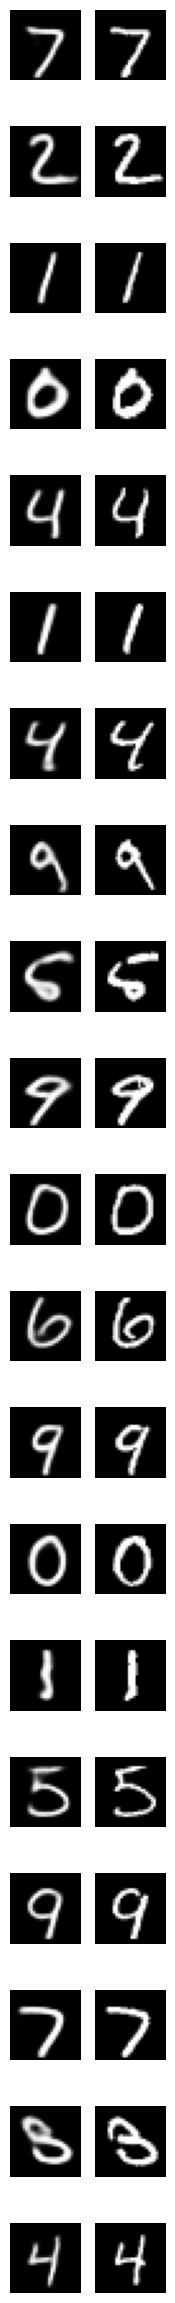

In [9]:
# Display a generated image from the decoder
tst_img  = test_images[:20]
tst_labels = test_labels[:20]
mean, logvar = encode(tst_img, tst_labels)
z = reparameterize(mean, logvar)
predictions = sample(z, tst_labels)
fig = plt.figure(figsize=(2,30))
for i in range(predictions.shape[0]):
    plt.subplot(20, 2, i*2+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(20, 2, i*2+2)
    plt.imshow(tst_img[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

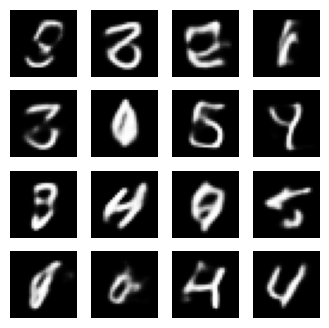

In [10]:
z = tf.random.normal(shape=(16, 50), mean=0., stddev=1.)
labels = tf.random.uniform(shape=(16,1), minval=0, maxval=10, dtype=tf.int32)
predictions = sample(z, labels)
fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0], cmap='gray')
    plt.axis('off')

(100, 1)


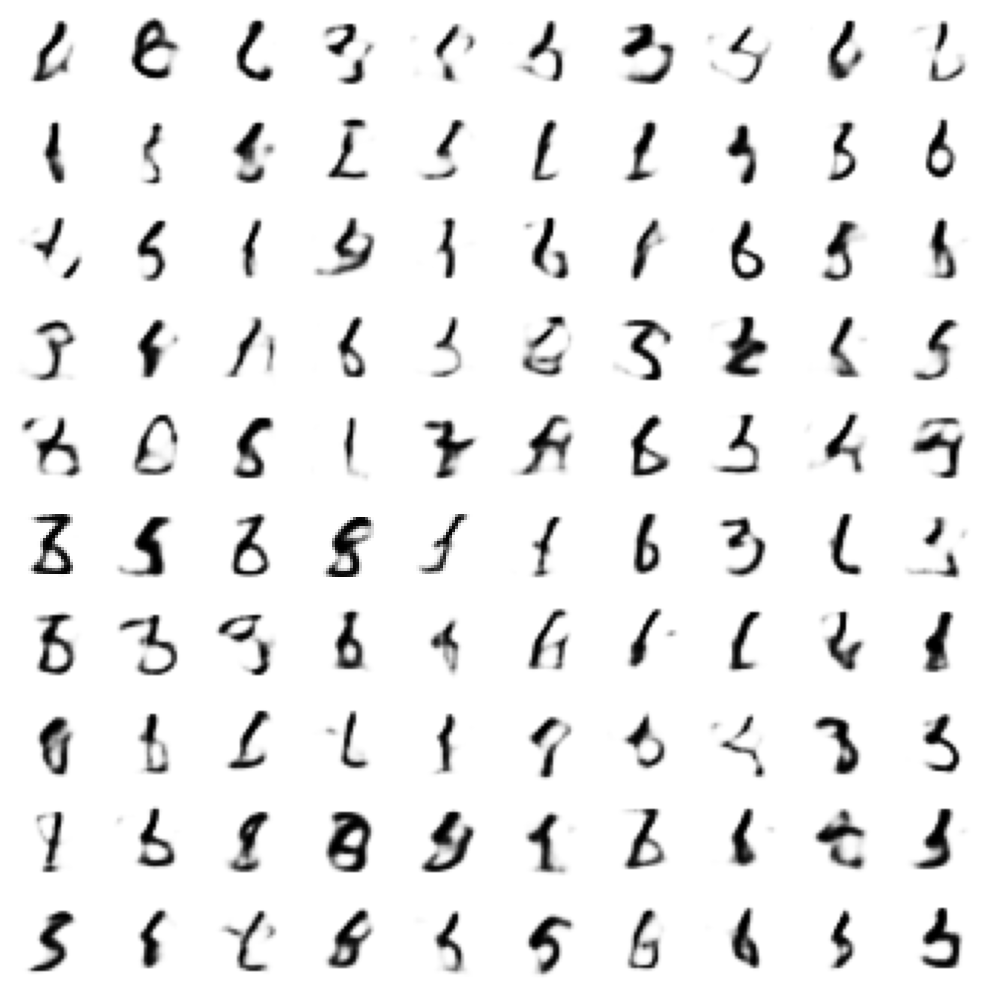

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [7]
 [7]
 [7]
 [7]
 [7]
 [7]
 [7]
 [7]
 [7]
 [7]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [9]
 [9]
 [9]
 [9]
 [9]
 [9]
 [9]
 [9]
 [9]
 [9]]


In [14]:
#Show examples of digit where first row is ones, second row is twos, etc.
z = tf.random.normal(shape=(100, 50), mean=-1., stddev=1.)
label = np.arange(10).reshape(-1, 1)
label = np.repeat(label, 10, axis=0)
print(label.shape)
generated_images = sample(z, label)
# # Show the images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()
print(label)